In [1]:
import seaborn as sns
import pandas as pd
from datetime  import timedelta

In [2]:
orders = pd.read_csv('orders.csv')
orders.drop("Unnamed: 0",axis=1,inplace=True)

In [3]:
orders.head()

,product,orderId,clientId,gender,orderdate,Sale
0,高麗菜,582,230,female,2017-01-08,10
1,高麗菜,2,276,male,2017-02-18,10
2,高麗菜,725,277,female,2017-02-03,10
3,高麗菜,597,279,male,2017-03-05,10
4,高麗菜,761,92,female,2017-02-08,10


In [4]:
orders['orderdate'] = pd.to_datetime(orders['orderdate'], format = '%Y-%m-%d')
# 設定分析日期 '2017-04-11'
today = pd.Timestamp(2017, 4, 11)
# 計算交易日期到現在幾天
orders['periode'] = today - orders['orderdate']

In [5]:
def classpriod(val):
    if val >timedelta(days=55):
        return '>55 day'
    
    elif val >=timedelta(days=31) and val <timedelta(days=55) :
        return '31-55 day'
    elif val >=timedelta(days=23) and val <timedelta(days=30) :
        return '23-30 day'
    elif val >=timedelta(days=16) and val <timedelta(days=22) :
        return '16-22 day'
    elif val >=timedelta(days=8) and val <timedelta(days=15) :
        return '8-15 day'
    else:
        return '0-7 day' 
orders['periodeclass']  = orders['periode'].apply(classpriod)  #R:recency :最近一次消費

In [6]:
orders['value'] = 1

In [7]:
orders.head()

,product,orderId,clientId,gender,orderdate,Sale,periode,periodeclass,value
0,高麗菜,582,230,female,2017-01-08,10,93 days,>55 day,1
1,高麗菜,2,276,male,2017-02-18,10,52 days,31-55 day,1
2,高麗菜,725,277,female,2017-02-03,10,67 days,>55 day,1
3,高麗菜,597,279,male,2017-03-05,10,37 days,31-55 day,1
4,高麗菜,761,92,female,2017-02-08,10,62 days,>55 day,1


In [8]:
countorder = orders[['clientId','periodeclass','gender','Sale','value']].groupby(['clientId','periodeclass','gender','Sale']).count().reset_index()
countorder.head()

,clientId,periodeclass,gender,Sale,value
0,1,16-22 day,male,10,4
1,1,16-22 day,male,50,2
2,1,23-30 day,male,10,4
3,1,23-30 day,male,50,2
4,1,31-55 day,male,10,3


In [9]:
countorder["newvalue"]=countorder[['clientId','periodeclass','value']].groupby(['clientId','periodeclass'])["value"].transform('sum')
#F:frequency :消費頻率
countorder.head()

,clientId,periodeclass,gender,Sale,value,newvalue
0,1,16-22 day,male,10,4,6
1,1,16-22 day,male,50,2,6
2,1,23-30 day,male,10,4,6
3,1,23-30 day,male,50,2,6
4,1,31-55 day,male,10,3,5


In [10]:
#M :money :消費金額
countorder["Sale"]=countorder["Sale"]*countorder["value"]
countorder.drop("value",axis=1,inplace=True)
countorder.head()

,clientId,periodeclass,gender,Sale,newvalue
0,1,16-22 day,male,40,6
1,1,16-22 day,male,100,6
2,1,23-30 day,male,40,6
3,1,23-30 day,male,100,6
4,1,31-55 day,male,30,5


In [11]:
def classcount(val):
    '''
    購買次數為標籤
    '''
    if val >20:
        return '>10 freq'
    elif val > 12 and val <= 20 :
        return '8-10 freq'
    elif val > 8 and val <= 12 :
        return '6-8 freq'
    elif val > 4 and val <= 8 :
        return '4-6 freq'
    elif val > 2 and val <= 4 :
        return '2-4 freq'
    elif  val <=2 :
        return '<=2 freq'
countorder['frequency']  = countorder['newvalue'].apply(classcount)

In [12]:
countorder.head()

,clientId,periodeclass,gender,Sale,newvalue,frequency
0,1,16-22 day,male,40,6,4-6 freq
1,1,16-22 day,male,100,6,4-6 freq
2,1,23-30 day,male,40,6,4-6 freq
3,1,23-30 day,male,100,6,4-6 freq
4,1,31-55 day,male,30,5,4-6 freq


In [15]:
countfinal = countorder[['periodeclass','frequency','gender',"Sale",'clientId']].groupby(['periodeclass','frequency','gender',"Sale"])["clientId"].count().reset_index()
countfinal.head()

,periodeclass,frequency,gender,Sale,clientId
0,0-7 day,2-4 freq,female,10,3
1,0-7 day,2-4 freq,female,20,3
2,0-7 day,2-4 freq,female,30,5
3,0-7 day,2-4 freq,female,40,2
4,0-7 day,2-4 freq,female,50,4


In [16]:
countfinal["Sale"]=countfinal["Sale"]*countfinal["clientId"]

In [17]:
countnew=countfinal[["periodeclass","gender","frequency","Sale"]].groupby(["periodeclass","gender","frequency"])["Sale"].sum().reset_index()
countnew=pd.DataFrame(countnew)
countnew.head()

,periodeclass,gender,frequency,Sale
0,0-7 day,female,2-4 freq,1070
1,0-7 day,female,4-6 freq,3690
2,0-7 day,female,6-8 freq,1370
3,0-7 day,female,8-10 freq,410
4,0-7 day,female,<=2 freq,260


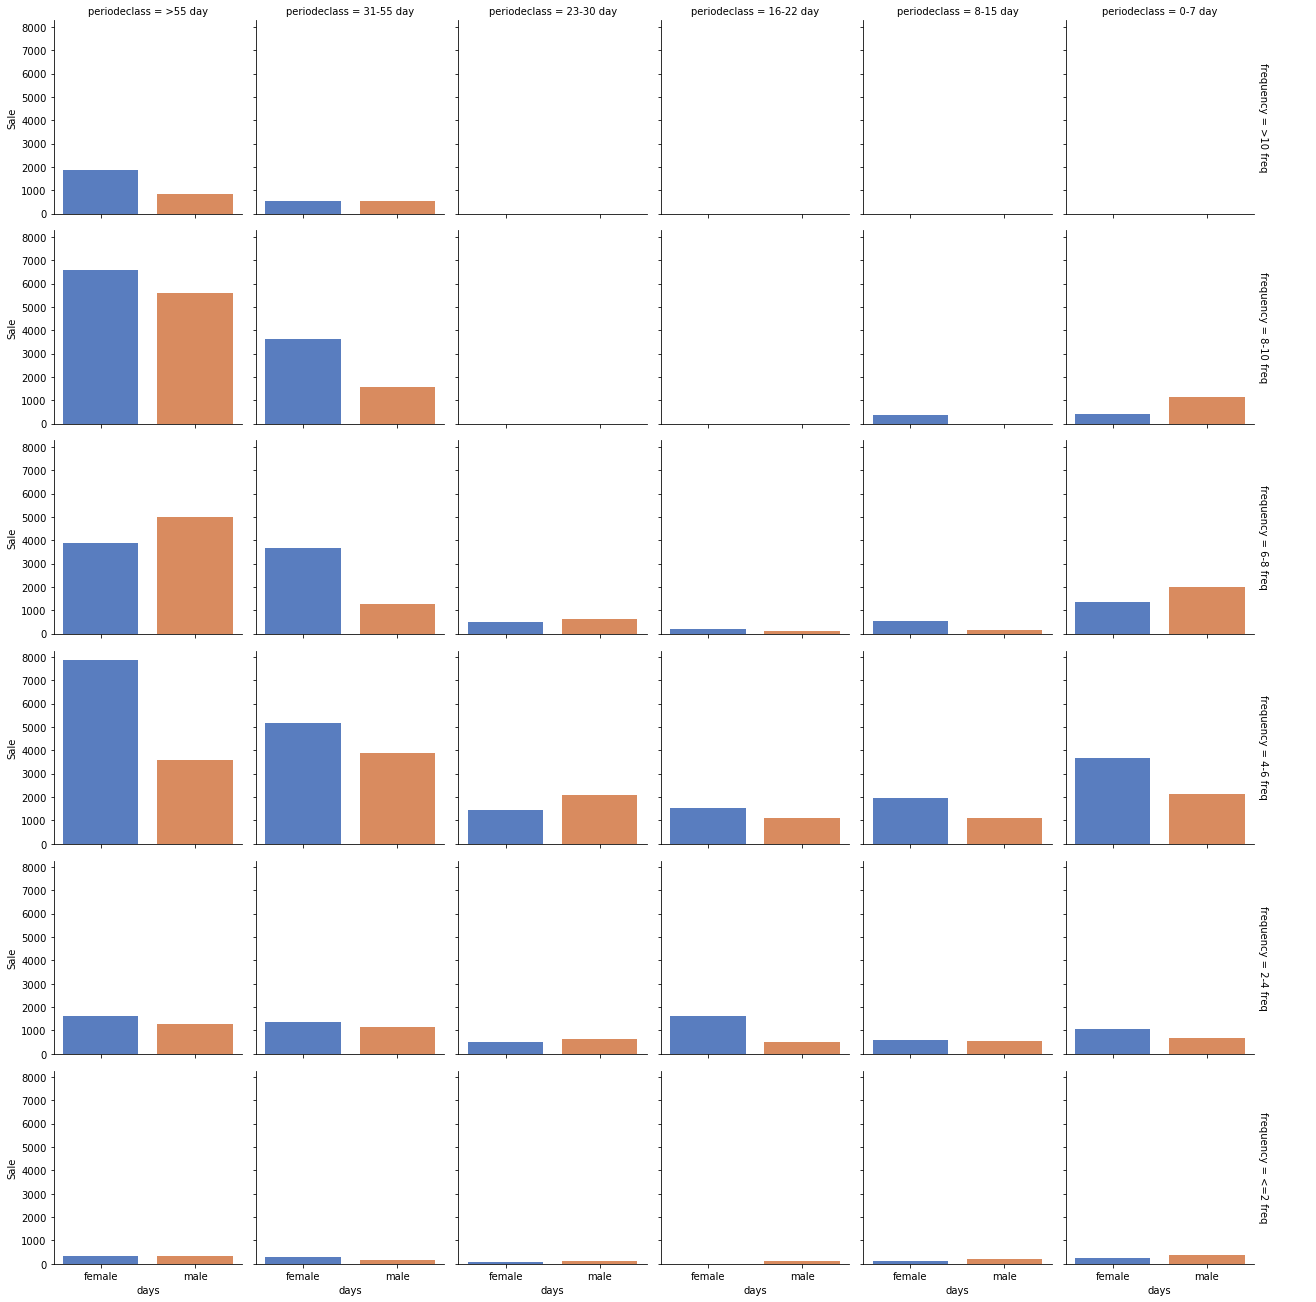

In [18]:
g = sns.FacetGrid(countnew, col="periodeclass",  row="frequency" ,
                  col_order= ['>55 day', '31-55 day', '23-30 day', '16-22 day', '8-15 day', '0-7 day'],
                  row_order= ['>10 freq','8-10 freq','6-8 freq','4-6 freq','2-4 freq' ,'<=2 freq'],
                  margin_titles=True)
g = g.map_dataframe(sns.barplot,y="Sale",x="gender",palette = sns.color_palette("muted"))
g = g.set_axis_labels('days','Sale').add_legend()